# Hotels ML Project 

En este notebook, elaboro un modelo de Machine Learning capaz de predecir si una reserva será o no cancelada con relativa precisión. Los datos son de https://www.kaggle.com/jessemostipak/hotel-booking-demand

# Imports

In [114]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Cargar datos y dividir en train y test para evitar contaminacion

In [2]:
hotel = pd.read_csv("hotel_bookings.csv")
espacio = "\n\n\n"
train_hotel, test_hotel = train_test_split(hotel, test_size=0.2, random_state=42)
# split lo primero de todo para no contaminar.

In [3]:
no_shows_analysis = train_hotel[['is_canceled', "reservation_status"]]
print(no_shows_analysis[no_shows_analysis['is_canceled'] == 1]['reservation_status'].value_counts())

print(espacio)

print(no_shows_analysis[no_shows_analysis['is_canceled'] == 0]['reservation_status'].value_counts())

Canceled    34280
No-Show       973
Name: reservation_status, dtype: int64




Check-Out    60259
Name: reservation_status, dtype: int64


# Analisis grafico target

In [ ]:
# target por hotel
hoteles_cancelaciones = train_hotel.pivot_table(index=['hotel'], columns=['is_canceled'], aggfunc = 'count')['adr']

hoteles_cancelaciones.plot(kind='bar', stacked=True,
           color=["g", "r"]);
plt.ylabel('Reservas', fontsize = 12)
plt.xlabel('Hotel', fontsize = 12)
plt.xticks(rotation=0,fontsize = 12)
plt.title('Distribucion reservas por hotel', fontsize = 14);

In [ ]:
# target general

target_info = no_shows_analysis[no_shows_analysis['is_canceled'] == 1]\
['reservation_status'].value_counts().append(no_shows_analysis[no_shows_analysis['is_canceled'] == 0]['reservation_status'].value_counts())

target_info = target_info.sort_values(ascending = False)
target_info = pd.DataFrame(target_info)

target_info['Target Label'] = [0, 1, 1]

fig, ax = plt.subplots(figsize = (10,7))    

y= target_info['reservation_status'].values



sns.barplot(x = target_info['reservation_status'],
           y = target_info.index,
           hue = target_info['Target Label'],
           palette=["g", "r"], ax = ax)

ax.set_xlim(0, 70000)
plt.xlabel('Reservas', fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('Distribucion de las reservas', fontsize = 15)


In [55]:
proporcion_cancel = pd.DataFrame(no_shows_analysis[no_shows_analysis['is_canceled'] == 
                               1]['reservation_status'].value_counts()).append(pd.DataFrame(no_shows_analysis[no_shows_analysis['is_canceled'] == 0]['reservation_status'].value_counts()))

In [69]:
print("% reservas canceladas o no show ="
      ,round(proporcion_cancel['reservation_status'][0:2].sum()/proporcion_cancel['reservation_status'].sum(), 4)*100)

% reservas canceladas o no show = 36.91


Vemos que en el target, 1 incluye tanto cancelaciones como no shows, mientras que 0 son reservas completadas

# Distribucion de variables

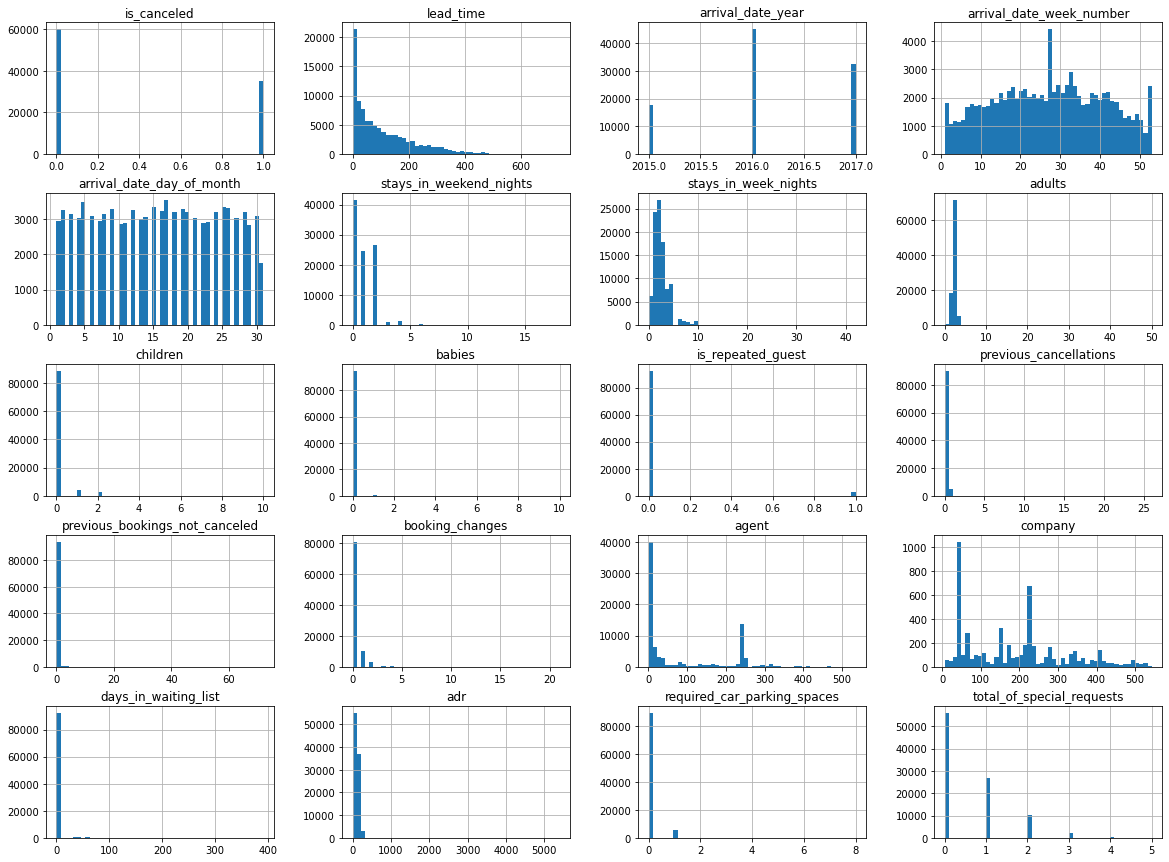

In [6]:
train_hotel.hist(bins = 50, figsize = (20,15));

La mayoria de variables numericas son muy asimetricas y tienen colas pronunciadas a la derecha

# Analisis paises de origen

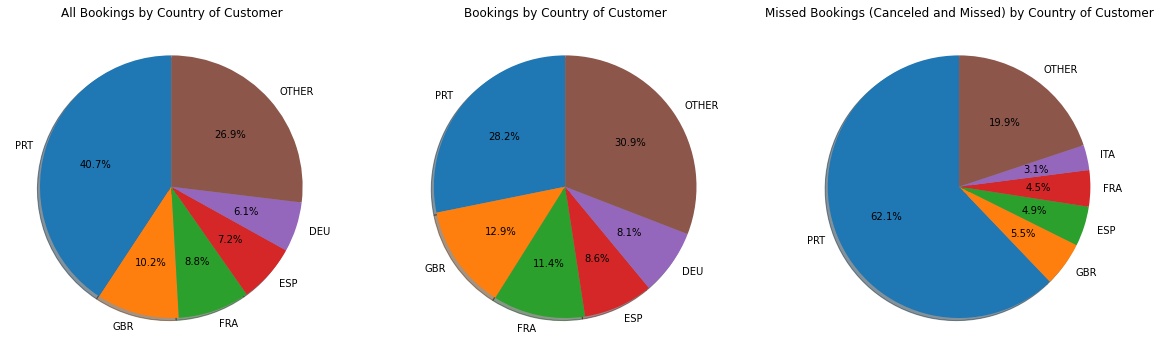

<Figure size 1440x1440 with 0 Axes>

In [8]:
hotel_made = train_hotel[train_hotel['is_canceled'] == 0]
hotel_cancel = train_hotel[train_hotel['is_canceled'] == 1]

bookings_country = pd.DataFrame(train_hotel["country"].value_counts()/train_hotel['country'].value_counts().sum()) # passangers % country
perc_cancel_country = pd.DataFrame(hotel_made["country"].value_counts()/hotel_made ["country"].value_counts().sum())
perc_made_country = pd.DataFrame(hotel_cancel["country"].value_counts()/hotel_cancel["country"].value_counts().sum())

countries = bookings_country.merge(perc_cancel_country, how = 'outer', \
                       right_index = True, left_index = True).merge(perc_made_country, how = 'outer', \
                       right_index = True, left_index = True)
countries.rename(columns = {'country_x' : "bookings_country",
                           'country_y' : 'perc_cancel_country',
                           'country' : "perc_made_country"}, inplace = True)

top5book = countries['bookings_country'][countries['bookings_country'].notna()].sort_values(ascending = False)[:5]
top5book_other = pd.Series(countries['bookings_country'][countries['bookings_country'].notna()].sort_values(ascending = False)[5:].sum(),
         index = ['OTHER'])

top5cancel = countries['perc_cancel_country'][countries['perc_cancel_country'].notna()].sort_values(ascending = False)[:5]
top5cancel_other = pd.Series(countries['perc_cancel_country'][countries['perc_cancel_country'].notna()].sort_values(ascending = False)[5:].sum(),
         index = ['OTHER'])

top5made = countries['perc_made_country'][countries['perc_made_country'].notna()].sort_values(ascending = False)[:5]
top5made_other = pd.Series(countries['perc_made_country'][countries['perc_made_country'].notna()].sort_values(ascending = False)[5:].sum(),
         index = ['OTHER'])

top6book = top5book.append(top5book_other)

top6cancel = top5cancel.append(top5cancel_other)

top6made = top5made.append(top5made_other)



fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,12))

plt.figure(figsize = (20,20))


ax1.pie(top6book.values, labels=top6book.index, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax2.pie(top6cancel.values, labels=top6cancel.index, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax3.pie(top6made.values, labels=top6made.index, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax1.title.set_text('All Bookings by Country of Customer')
ax2.title.set_text('Bookings by Country of Customer')
ax3.title.set_text('Missed Bookings (Canceled and Missed) by Country of Customer')


plt.show(); 

# Feature Engineering TRAIN

hecho el analisis preliminar de los datos, toca limpiar y manipular los datos de train (missings, nuevas variables, transformaciones...) para que estos le encajen bien a los distintos algoritmos de ML

In [10]:
train_hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
67702,City Hotel,1,64,2017,May,18,6,2,1,3,...,No Deposit,9.0,NaN,0,Transient,189.00,0,0,Canceled,2017-03-13
115851,City Hotel,0,34,2017,July,28,10,1,1,2,...,No Deposit,14.0,NaN,0,Transient,146.00,0,0,Check-Out,2017-07-12
57345,City Hotel,1,8,2016,September,39,24,1,1,2,...,No Deposit,9.0,NaN,0,Transient,259.00,0,0,Canceled,2016-09-16
11622,Resort Hotel,1,251,2017,May,21,21,2,4,2,...,No Deposit,NaN,NaN,0,Transient,89.70,0,1,Canceled,2016-09-12
33333,Resort Hotel,0,23,2017,February,7,18,1,1,2,...,No Deposit,241.0,NaN,0,Transient,42.43,0,1,Check-Out,2017-02-20


In [11]:
train_hotel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95512 entries, 67702 to 15795
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           95512 non-null  object 
 1   is_canceled                     95512 non-null  int64  
 2   lead_time                       95512 non-null  int64  
 3   arrival_date_year               95512 non-null  int64  
 4   arrival_date_month              95512 non-null  object 
 5   arrival_date_week_number        95512 non-null  int64  
 6   arrival_date_day_of_month       95512 non-null  int64  
 7   stays_in_weekend_nights         95512 non-null  int64  
 8   stays_in_week_nights            95512 non-null  int64  
 9   adults                          95512 non-null  int64  
 10  children                        95508 non-null  float64
 11  babies                          95512 non-null  int64  
 12  meal                        

## Encoding hotel 0/1

Primeramente, convertimos la columna del tipo de hotel en dummy

In [12]:
# Encoding hotel
def mapping(x):
    if x == 'Resort Hotel':
        return 0
    if x == 'City Hotel':
        return 1
    else:
        return 9999
train_hotel['hotel'] = train_hotel['hotel'].apply(mapping)

<ipython-input-12-6ed28a423b3f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_hotel['hotel'] = train_hotel['hotel'].apply(mapping)


## Drop columns

Drop compania y agente (muchos missings y muchisimas categorias) y assigned room type (analisis rapido intuye que podria contener demasiada info sobre el target). El 95% de las reservas en las que se cambio la habitacion a una distinta de la reservada, el cliente acudió, cifra muy distinta de los 2/3 de las reservas que acuden para todos los datos. Esto podria ser porque casi todos los cambios de habitación ocurren una vez el cliente llega al hotel. Si nuestro objetivo es predecir si la reserva acudirá o no, incluir una variable que suele rellenarse a posteriori una vez sabemos que el cliente ha acudido al hotel no tiene mucho sentido.

Tambien quito booking changes porque esto no es algo que se pueda saber en el momento en que una reserva es efectuada, que es el punto en el que nuestro modelo analizaria los datos.

Podria ser interesante incluirla si el modelo fuera dinamico y cada dia hasta el momento de la reserva devolviera una probabilidad de cancelacion.


In [13]:
(train_hotel[(train_hotel['assigned_room_type'] != train_hotel['reserved_room_type'])]['is_canceled'].value_counts())\
/len(train_hotel[(train_hotel['assigned_room_type'] != train_hotel['reserved_room_type'])]['is_canceled'])*100

0    94.475648
1     5.524352
Name: is_canceled, dtype: float64

In [14]:
# drop columns with many missings, info about target or dates
train_hotel.drop(columns = ['company',
                           'assigned_room_type',
                           'reservation_status',
                            'booking_changes',
                           'reservation_status_date'], inplace = True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Tratar missings

In [15]:
# drop missings COUNTRY 
train_hotel = train_hotel[train_hotel['country'].notna()]
# missings CHILDREN asumen moda de train
train_hotel['children'].fillna(train_hotel['children'].mode().values[0],
                             inplace = True)
train_hotel['agent'].fillna(0, inplace = True)


## Fechas

In [16]:
# crear un diccionario con meses - numeros
meses = list(train_hotel.arrival_date_month.unique())

dict_meses = {meses[0]:5,
meses[1]:7,
meses[2]:9,
meses[3]:2,
meses[4]:10,
meses[5]:6,
meses[6]:4,
meses[7]:3,
meses[8]:11,
meses[9]:8,
meses[10]:12,
meses[11]:1}

#mapear el diccionario a la columna mes
train_hotel['arrival_date_month'] = train_hotel['arrival_date_month'].map(dict_meses)

#renombrar columnas (facilita conversion a date time)
train_hotel.rename(columns = {'arrival_date_year' : 'year',
                                'arrival_date_month' : 'month',
                                'arrival_date_day_of_month' : 'day'},
                     inplace = True)

# crear columna con fecha de llegada completa
train_hotel['arrival_date'] = pd.to_datetime(train_hotel[['year', 'month', 'day']])

# montar dummy de si es verano o no
dict_season = {1:0,
2:0,
3:0,
4:0,
5:0,
6:1,
7:1,
8:1,
9:0,
10:0,
11:0,
12:0}

train_hotel["Summer Season"] = train_hotel['month'].map(dict_season)


## Elimino datos anomalos por precio y estancia

In [17]:
# creo columna total noches reservadas para identificar anomalias
train_hotel['total_days_stay'] = train_hotel['stays_in_week_nights'] + train_hotel['stays_in_weekend_nights']

# me quedo con aquellas reservas que tengan noches reservadas en el hotel y que no tengan precios negativos o erroneos

train_hotel = train_hotel[(train_hotel['adr'] >= 0 ) & (train_hotel['adr'] < 2000)]


## Other countries

Mi objetivo es crear dummies con variables categoricas como el pais. Sin embargo, hay tantos paises que esto desembocaria en un modelo con demasiadas features. Por ende, me quedo los paises de origen de los clientes que mas se repiten y el resto los asigno a "Otro", de tal forma que cuando coja dummies de los paises no acabe con ciento y pico nuevas features

In [18]:
# Analisis para elegir con que paises quedarme en dummies y cuales poolear en "OTHER"

total_clients_country = pd.DataFrame(train_hotel['country'].value_counts())
total_cancels_country = pd.DataFrame(train_hotel[train_hotel['is_canceled'] == 1]['country'].value_counts())
total_clients_country.rename(columns = {'country' : 'total reservations'},
                            inplace = True)
total_cancels_country.rename(columns = {'country' : 'total cancellations'},
                            inplace = True)

country_analysis = total_clients_country.merge(total_cancels_country, how = 'outer', 
                                               left_index = True, right_index = True).fillna(0)

country_analysis

,total reservations,total cancellations
ABW,1,0.0
AGO,288,164.0
AIA,1,0.0
ALB,9,1.0
AND,5,4.0
...,...,...
VGB,1,1.0
VNM,8,2.0
ZAF,66,28.0
ZMB,2,1.0


In [19]:
# Analisis para elegir con que paises quedarme en dummies y cuales pooler en "OTHER"

avg_cancel = country_analysis['total cancellations'].sum()/country_analysis['total reservations'].sum()
print("De media un", round(avg_cancel*100, 3), "% de las reservas son canceladas" )

De media un 36.999 % de las reservas son canceladas


count      174.000000
mean       546.758621
std       3164.083205
min          1.000000
25%          2.000000
50%          9.500000
75%         61.500000
max      38759.000000
Name: total reservations, dtype: float64

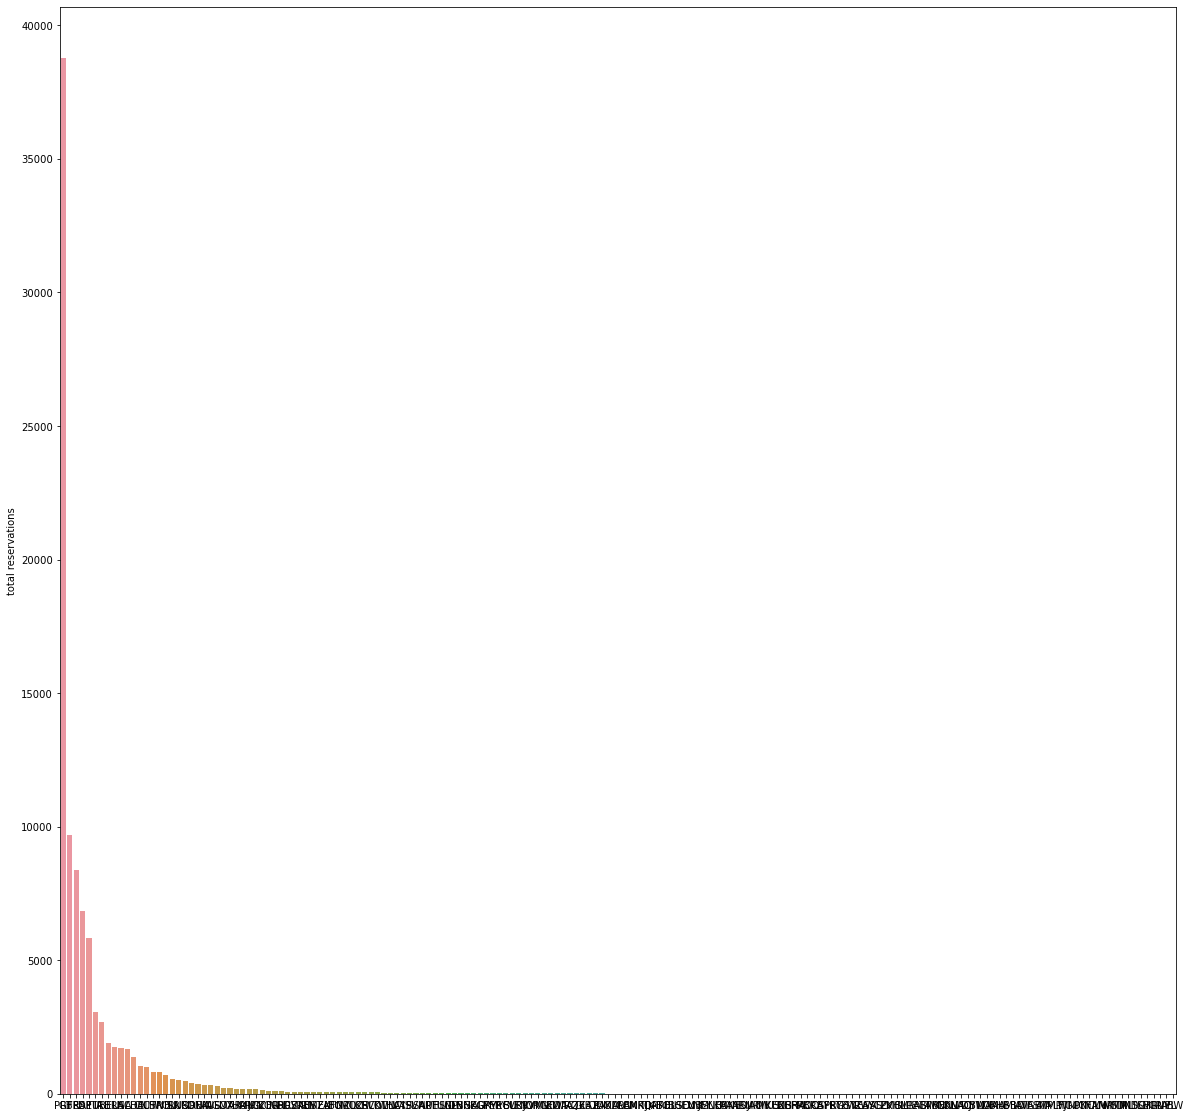

In [20]:
# Analisis para elegir con que paises quedarme en dummies y cuales pooler en "OTHER"

country_analysis['%cancels'] = country_analysis['total cancellations']/country_analysis['total reservations']
country_analysis = country_analysis.sort_values('total reservations',
                            ascending = False)

plt.figure(figsize = (20,20))

sns.barplot(data = country_analysis,
            x = country_analysis.index,
           y = 'total reservations'
           );
country_analysis['total reservations'].describe()

In [21]:
# me quedo con paises con mas de 500 reservas en train, el resto pasaran a ser "OTHER" en el dataset
paises_incluir = list(country_analysis[country_analysis['total reservations'] > 500].sort_values('%cancels')['%cancels'].index)
otros_paises = [item for item in list(train_hotel['country'].unique()) if item not in paises_incluir]
train_hotel['country'].replace(to_replace = otros_paises, value = 'OTHER', inplace = True)

In [ ]:
train_hotel.info()

# Misma cosa con agente

In [22]:
train_hotel['agent']

67702       9.0
115851     14.0
57345       9.0
11622       0.0
33333     241.0
          ...  
76820       0.0
110268      9.0
103694     22.0
860       240.0
15795       0.0
Name: agent, Length: 95136, dtype: float64

In [23]:
value_counts_train_agent = train_hotel.groupby('agent').count()['hotel']
cancels_proportion_train_agent = train_hotel.groupby('agent')['is_canceled'].mean()
analisis_agentes = pd.DataFrame({'reservas' : value_counts_train_agent.values, 
             '%cancels' : cancels_proportion_train_agent.values}, index = cancels_proportion_train_agent.index)
analisis_agentes = analisis_agentes.sort_values('reservas', ascending = False)
agencias_me_quedo = list(analisis_agentes[analisis_agentes['reservas'] > 500].index)
otras_agencias = [item for item in list(train_hotel['agent'].unique()) if item not in agencias_me_quedo]
train_hotel['agent'].replace(to_replace = otras_agencias, value = 888, inplace = True)


## Dummies

In [24]:
# copy before dummies
train_hotel_no_dummies = train_hotel

In [25]:
train_hotel = pd.get_dummies(train_hotel, columns = ['meal',
                         "market_segment",
                         'distribution_channel',
                         'deposit_type',
                         'customer_type',
                         'reserved_room_type',
                         'agent',
                         'country'],
              drop_first = True)

In [26]:
train_hotel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95136 entries, 67702 to 15795
Data columns (total 91 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   hotel                           95136 non-null  int64         
 1   is_canceled                     95136 non-null  int64         
 2   lead_time                       95136 non-null  int64         
 3   year                            95136 non-null  int64         
 4   month                           95136 non-null  int64         
 5   arrival_date_week_number        95136 non-null  int64         
 6   day                             95136 non-null  int64         
 7   stays_in_weekend_nights         95136 non-null  int64         
 8   stays_in_week_nights            95136 non-null  int64         
 9   adults                          95136 non-null  int64         
 10  children                        95136 non-null  float64       
 11

In [27]:
train_hotel.columns

Index(['hotel', 'is_canceled', 'lead_time', 'year', 'month',
       'arrival_date_week_number', 'day', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'days_in_waiting_list', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'arrival_date', 'Summer Season', 'total_days_stay', 'meal_FB',
       'meal_HB', 'meal_SC', 'meal_Undefined', 'market_segment_Complementary',
       'market_segment_Corporate', 'market_segment_Direct',
       'market_segment_Groups', 'market_segment_Offline TA/TO',
       'market_segment_Online TA', 'market_segment_Undefined',
       'distribution_channel_Direct', 'distribution_channel_GDS',
       'distribution_channel_TA/TO', 'distribution_channel_Undefined',
       'deposit_type_Non Refund', 'deposit_type_Refundable',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_T

## Quitar columnas que el modelo no sabe interpretar

In [28]:
train_hotel.drop(columns = ['year', 'month',
       'arrival_date_week_number', 'day', 'arrival_date', 'total_days_stay'],
                inplace = True)

In [ ]:
train_hotel.info()

## Transf logaritmica

In [29]:
train_hotel_trans = train_hotel.copy()
columnas_transf = ['lead_time', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
    'previous_cancellations',
       'previous_bookings_not_canceled',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests']

for i in columnas_transf:
    train_hotel_trans[i] = np.log(train_hotel_trans[i] + 1)

## Divido en X e Ys

In [32]:
# X e ys

X_train_trans = train_hotel_trans.drop(columns = ['is_canceled'])
y_train_trans = train_hotel_trans['is_canceled']

## Estandarizacion

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train_trans)
X_train_trans_nor = scaler.transform(X_train_trans)

____________

_______________

_______________

# ---Modelos---

# Primer intento de modelo: log reg

In [40]:
from sklearn import linear_model


grid_log_reg = {                   
                     "penalty": ["l1","l2"], # Regularizaciones L1 y L2.
                     "C": [0.1, 0.5, 1.0, 5.0], # Cuanta regularizacion queremos
                     
                     "max_iter": [50,100,500],  # Iteraciones del Gradient Descent. No suele impactar mucho
                                                # pero en ocasiones aparecen warnings diciendo que se aumente
                     
                     "solver": ["liblinear"]  # Suele ser el más rápido
                    }

log_reg=LogisticRegression()

log_reg_cv=GridSearchCV(log_reg,grid_log_reg,cv=5)

log_reg_cv.fit(X_train_trans_nor, y_train_trans)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.5, 1.0, 5.0], 'max_iter': [50, 100, 500],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [41]:
print("tuned hpyerparameters :(best parameters) ",log_reg_cv.best_params_)
print("accuracy :",log_reg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 5.0, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy : 0.8282143497906382


In [ ]:
predictions = log_reg_cv.predict(X_train)
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(y_train, predictions)
import seaborn as sns
sns.heatmap(c_matrix, annot=True, fmt='g');

## Random forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

grid_random_forest = {"n_estimators": [150], # El Random Forest no suele empeorar por exceso de
                                             # estimadores. A partir de cierto numero no merece la pena
                                             # perder el tiempo ya que no mejora mucho más la precisión.
                                             # Entre 100 y 200 es una buena cifra

                     
                     "max_depth": [24,30,35], # No le afecta tanto el overfitting como al decissiontree.
                                                      # Podemos probar mayores profundidades
                      
                     "max_features": ["sqrt", 3, 4] # Numero de features que utiliza en cada split.
                                                    # cuanto más bajo, mejor generalizará y menos overfitting.
                                                    
                     }



rnd_clf=RandomForestClassifier()

rnd_clf_cv=GridSearchCV(rnd_clf,grid_random_forest,cv=5)

rnd_clf_cv.fit(X_train_trans_nor, y_train_trans)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [24, 30, 35],
                         'max_features': ['sqrt', 3, 4],
                         'n_estimators': [150]})

In [44]:
print("tuned hpyerparameters :(best parameters) ",rnd_clf_cv.best_params_)
print("accuracy :",rnd_clf_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 35, 'max_features': 'sqrt', 'n_estimators': 150}
accuracy : 0.8803817553933708


# KNN

In [73]:
from sklearn.neighbors import KNeighborsClassifier
param_grid = {'n_neighbors': np.arange(2,8)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5,return_train_score = False,n_jobs = -1)
knn_cv.fit(X_train_trans_nor, y_train_trans)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([2, 3, 4, 5, 6, 7])})

In [106]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'n_neighbors': 6}
accuracy : 0.8431087892658518


# XGBoost

In [126]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier()


grid_xgb = {"n_estimators": [120],
            "max_depth": [8, 24, 30, 35],
            "learning_rate" : [0.3]
                                                      
                      }



xgb_clf_cv=GridSearchCV(xgb_clf,grid_xgb,cv=5)

xgb_clf_cv.fit(X_train_trans_nor, y_train_trans)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

# Preparar datos de test

In [77]:
test_hotel

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
30946,Resort Hotel,0,203,2016,December,49,2,2,5,2,...,No Deposit,250.0,NaN,0,Transient,66.80,0,0,Check-Out,2016-12-09
40207,City Hotel,1,82,2015,July,29,16,0,3,2,...,No Deposit,9.0,NaN,0,Transient,76.50,0,0,Canceled,2015-07-16
103708,City Hotel,0,25,2016,December,53,27,0,3,3,...,No Deposit,220.0,NaN,0,Transient-Party,60.00,0,1,Check-Out,2016-12-30
85144,City Hotel,0,1,2016,March,11,9,0,1,1,...,No Deposit,9.0,NaN,0,Transient-Party,95.00,0,0,Check-Out,2016-03-10
109991,City Hotel,0,70,2017,April,16,16,2,2,2,...,No Deposit,9.0,NaN,0,Transient,108.00,0,0,Check-Out,2017-04-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48376,City Hotel,1,251,2016,March,13,22,0,3,1,...,Non Refund,29.0,NaN,93,Transient,90.00,0,0,Canceled,2015-10-16
19712,Resort Hotel,0,152,2015,December,52,26,2,5,2,...,No Deposit,147.0,NaN,0,Transient,48.98,0,0,Check-Out,2016-01-02
32188,Resort Hotel,0,40,2017,January,3,16,1,2,1,...,No Deposit,NaN,NaN,0,Transient-Party,55.00,0,0,Check-Out,2017-01-19
92983,City Hotel,0,109,2016,July,29,10,2,3,2,...,No Deposit,16.0,NaN,0,Transient,102.25,0,0,Check-Out,2016-07-15


# Hotel y drop

In [78]:
#map hotel
test_hotel['hotel'] = test_hotel['hotel'].apply(mapping)

# drop columns with many missings, info about target or dates
test_hotel.drop(columns = ['company',
                           'assigned_room_type',
                           'reservation_status',
                           'booking_changes',
                           'reservation_status_date'], inplace = True)

<ipython-input-78-f9dc9d14de1a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_hotel['hotel'] = test_hotel['hotel'].apply(mapping)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# missings

In [79]:
# Check missings
test_hotel.isna().any()[test_hotel.isna().any() == True]

country    True
agent      True
dtype: bool

Solo hay missings en la columna de paises

In [80]:
# relleno los missings con portugal, el pais mas frecuente en train
test_hotel['country'].fillna(train_hotel_no_dummies['country'].mode().values[0],
                             inplace = True)

test_hotel['agent'].fillna(0, inplace = True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4529: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [81]:
test_hotel.isna().any()[test_hotel.isna().any() == True]

Series([], dtype: bool)

ya no hay missings en test

# Fechas

In [82]:
#mapear el diccionario a la columna mes
test_hotel['arrival_date_month'] = test_hotel['arrival_date_month'].map(dict_meses)

#renombrar columnas (facilita conversion a date time)
test_hotel.rename(columns = {'arrival_date_year' : 'year',
                                'arrival_date_month' : 'month',
                                'arrival_date_day_of_month' : 'day'},
                     inplace = True)

# crear columna con fecha de llegada completa
test_hotel['arrival_date'] = pd.to_datetime(test_hotel[['year', 'month', 'day']])

test_hotel["Summer Season"] = test_hotel['month'].map(dict_season)

<ipython-input-82-b1c619e7ca84>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_hotel['arrival_date_month'] = test_hotel['arrival_date_month'].map(dict_meses)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-82-b1c619e7ca84>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

# Otros paises

In [83]:
otros_paises_test = [i for i in test_hotel['country'].unique() if i not in paises_incluir] 

In [84]:
test_hotel['country'].replace(to_replace = otros_paises_test, value = 'OTHER', inplace = True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4575: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [85]:
test_hotel['country'].nunique()

20

# Agente

In [86]:
otras_agencias_test = [item for item in list(test_hotel['agent'].unique()) if item not in agencias_me_quedo]
test_hotel['agent'].replace(to_replace = otras_agencias_test, value = 888, inplace = True)


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4575: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


# Quitar columnas que no sirven

In [87]:
test_hotel.drop(columns = ['year', 'month',
       'arrival_date_week_number', 'day', 'arrival_date',],
                inplace = True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Dummies

In [88]:
# copy before dummies
test_hotel_no_dummies = test_hotel

In [89]:
test_hotel = pd.get_dummies(test_hotel, columns = ['meal',
                         "market_segment",
                         'distribution_channel',
                         'deposit_type',
                         'customer_type',
                         'reserved_room_type',
                         'agent',
                         'country'],
              drop_first = True)

In [90]:
missing_cols = set(train_hotel.columns) -  set(test_hotel.columns)

#creo columna de ceros en test por cada una de estas variables

for c in missing_cols:
    test_hotel[c] = 0
    
#test y train con mismo orden
test_hotel = test_hotel[train_hotel.columns]

## Transformacion logaritmica

In [91]:
test_hotel_trans = test_hotel.copy()
columnas_transf = ['lead_time', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
    'previous_cancellations',
       'previous_bookings_not_canceled',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests']

for i in columnas_transf:
    test_hotel_trans[i] = np.log(test_hotel_trans[i] + 1)

## Divido en X e y 

In [92]:
# X e ys

X_test_trans = test_hotel_trans.drop(columns = ['is_canceled'])
y_test_trans = test_hotel_trans['is_canceled']

## Estandarizacion

In [104]:
# el scaler ya esta creado con X_train
X_test_trans_nor = scaler.transform(X_test_trans)

# Probar los mejores modelos en test

# Regresion logistica - test

In [95]:
log_reg_cv.best_params_

{'C': 5.0, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

In [101]:
log_reg_final = LogisticRegression(C= 5.0, max_iter= 100, penalty= 'l1', solver= 'liblinear')
log_reg_final.fit(X_train_trans_nor, y_train_trans)

LogisticRegression(C=5.0, penalty='l1', solver='liblinear')

In [105]:
log_reg_final.score(X_test_trans_nor, y_test_trans)

0.8328586983834492

In [117]:
log_reg_final_predictions = log_reg_final.predict(X_test_trans_nor)

In [118]:
print("Precision score:", precision_score(y_test_trans, log_reg_final_predictions))
print("Recall score:", recall_score(y_test_trans, log_reg_final_predictions))
print("F1 score:", f1_score(y_test_trans, log_reg_final_predictions))

Precision score: 0.8223718280683584
Recall score: 0.7080593021959648
F1 score: 0.7609463911350703


# KNN - test

In [107]:
knn_cv.best_params_

{'n_neighbors': 6}

In [108]:
knn_final = KNeighborsClassifier(n_neighbors = 6)
knn_final.fit(X_train_trans_nor, y_train_trans)

KNeighborsClassifier(n_neighbors=6)

In [109]:
knn_final.score(X_test_trans_nor, y_test_trans)

0.8485216517296256

In [120]:
knn_final_predictions = knn_final.predict(X_test_trans_nor)

In [121]:
print("Precision score:", precision_score(y_test_trans, knn_final_predictions))
print("Recall score:", recall_score(y_test_trans, knn_final_predictions))
print("F1 score:", f1_score(y_test_trans, knn_final_predictions))

Precision score: 0.8434693353861945
Recall score: 0.7328057072790102
F1 score: 0.784252907843722


# Random forest - test

In [110]:
rnd_clf_final=RandomForestClassifier(n_estimators = 150,
                                     max_depth = 30,
                                     max_features = 'sqrt')
rnd_clf_final.fit(X_train_trans_nor, y_train_trans)


RandomForestClassifier(max_depth=30, max_features='sqrt', n_estimators=150)

In [111]:
rnd_clf_final.score(X_test_trans_nor, y_test_trans)

0.8881397101934836

In [122]:
rnd_clf_final_predictions = rnd_clf_final.predict(X_test_trans_nor)

In [ ]:
trnd_clf_final_c_matrix = confusion_matrix(y_test_trans, rnd_clf_final_predictions)
sns.heatmap(trnd_clf_final_c_matrix, annot=True, fmt='g');

In [124]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print("Precision score:", precision_score(y_test_trans, rnd_clf_final_predictions))
print("Recall score:", recall_score(y_test_trans, rnd_clf_final_predictions))
print("F1 score:", f1_score(y_test_trans, rnd_clf_final_predictions))

Precision score: 0.8762541806020067
Recall score: 0.8177460706721659
F1 score: 0.8459897364931096


## XGBoost

In [129]:
y_pred_xgb = xgb_clf_cv.predict(X_test_trans_nor)

print("Precision score:", precision_score(y_test_trans, y_pred_xgb))
print("Recall score:", recall_score(y_test_trans, y_pred_xgb))
print("F1 score:", f1_score(y_test_trans, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test_trans, y_pred_xgb))

Precision score: 0.8575060672599099
Recall score: 0.8271095752981831
F1 score: 0.8420335905583296
Accuracy: 0.8834073205461094


# Por poco, el mejor modelo es el Random Forest

Por ultimo, ajustamos el threshold del modelo, puesto que en funcion de la necesidad de negocio, querremos un modelo que sea mas o menos restrictivo a la hora de decantarse por una u otra clase. En este caso, asumo que es mas prioritario no asignar falsos positivos (predecir como cancelacion una reserva que no lo acaba siendo)  

Text(33.0, 0.5, 'ACTUAL')

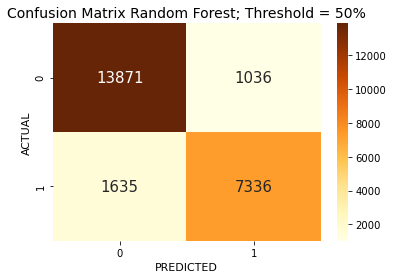

In [151]:
trnd_clf_final_c_matrix = confusion_matrix(y_test_trans, rnd_clf_final_predictions)
sns.heatmap(trnd_clf_final_c_matrix, annot=True, cmap=sns.color_palette("YlOrBr", as_cmap=True), 
            fmt='g', annot_kws={"fontsize":15})

plt.title('Confusion Matrix Random Forest; Threshold = 50%',
         fontsize = 14);
plt.xlabel('PREDICTED',
         fontsize = 11)
plt.ylabel('ACTUAL',
         fontsize = 11)

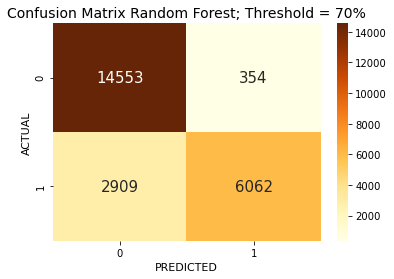

In [163]:
# pruebas con threshold, modelo threshold = 0.7 que sea mas exigente a la hora de predecir una cancelacion

predicted_proba = rnd_clf_final.predict_proba(X_test_trans_nor)
predicted70 = (predicted_proba [:,1] >= 0.7).astype('int')

trnd_clf_final_c_matrix_70 = confusion_matrix(y_test_trans, predicted70)

sns.heatmap(trnd_clf_final_c_matrix_70, annot=True, cmap=sns.color_palette("YlOrBr", as_cmap=True), 
            fmt='g', annot_kws={"fontsize":15})

plt.title('Confusion Matrix Random Forest; Threshold = 70%',
         fontsize = 14);
plt.xlabel('PREDICTED',
         fontsize = 11)
plt.ylabel('ACTUAL',
         fontsize = 11);

In [164]:
print("Precision score 0.7:", precision_score(y_test_trans, predicted70))
print("Recall score 0.7:", recall_score(y_test_trans, predicted70))
print("F1 score 0.7:", f1_score(y_test_trans, predicted70))

Precision score 0.7: 0.9448254364089775
Recall score 0.7: 0.6757329171775722
F1 score 0.7: 0.7879378696302074


In [167]:
print(trnd_clf_final_c_matrix[0,0]/(trnd_clf_final_c_matrix[0,0]+trnd_clf_final_c_matrix[0,1]))
print(trnd_clf_final_c_matrix[1,1]/(trnd_clf_final_c_matrix[1,0]+trnd_clf_final_c_matrix[1,1]))

0.9305024485141209
0.8177460706721659


In [168]:
print(trnd_clf_final_c_matrix_70[0,0]/(trnd_clf_final_c_matrix_70[0,0]+trnd_clf_final_c_matrix_70[0,1]))
print(trnd_clf_final_c_matrix_70[1,1]/(trnd_clf_final_c_matrix_70[1,0]+trnd_clf_final_c_matrix_70[1,1]))

0.9762527671563694
0.6757329171775722


In [154]:
thresholds = np.arange(0.05,1, 0.05)

predicted_proba = rnd_clf_final.predict_proba(X_test_trans_nor)

precisiones = []

recalls = []

for i in thresholds:
    
    predicted = (predicted_proba [:,1] >= i).astype('int')

    pr = precision_score(y_test_trans, predicted)
    
    precisiones.append(pr)

    rec = recall_score(y_test_trans, predicted)
    
    recalls.append(rec)



In [155]:
trade_off = pd.DataFrame({'Threshold para clasificar como cancelacion' : thresholds,
             'Recall': recalls,
             'Precisiones':precisiones})

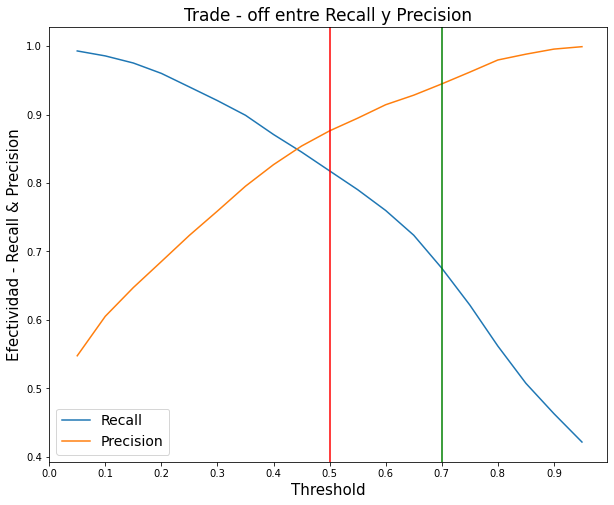

In [162]:
plt.figure(figsize =(10,8))
plt.plot(trade_off['Threshold para clasificar como cancelacion'],
         trade_off['Recall'], label = "Recall")
plt.plot(trade_off['Threshold para clasificar como cancelacion'],
         trade_off['Precisiones'], label = "Precision")
plt.xlabel('Threshold', fontsize = 15)
plt.axvline(0.5, c="r")
plt.axvline(0.7, c="green")
plt.ylabel('Efectividad - Recall & Precision', fontsize = 15)
plt.title('Trade - off entre Recall y Precision', fontsize = 17)
plt.xticks(np.arange(0, 1, 0.1))
plt.legend(fontsize = 14)
# Display a figure.
plt.show()